In [1]:
# Taller 1 - Clasificación de deficiencia de fósforo en hojas de maíz usando HOG y Árbol de Decisión
# Autor: ChatGPT
# Descripción: En este notebook implementamos un modelo para clasificar imágenes de hojas de maíz en 3 clases según su deficiencia de fósforo.
# Usamos extracción de características HOG, preprocesamiento y validación cruzada con árbol de decisión.

# ------------------------------------------
# 1. Importación de librerías necesarias
# ------------------------------------------
import os
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Librerías importadas correctamente.")


Librerías importadas correctamente.


In [2]:
# Sección 2. Definición de rutas y clases
# ------------------------------------------
# 2. Definición de rutas y clases
# ------------------------------------------
# Justificación:
# Definimos las rutas y etiquetas para facilitar la carga y organización de los datos.
# Esto asegura que el código sea flexible y fácil de mantener.

#ruta_base = "Taller_1"
ruta_base = "."

# Carpetas con las imágenes y sus etiquetas asociadas
clases = {
    "-C": 0,    # Hojas sanas
    "-P50": 1,  # Deficiencia al 50% fósforo
    "-P": 2     # Deficiencia total fósforo
}

print("Clases y rutas definidas correctamente.")

Clases y rutas definidas correctamente.


In [3]:
# Sección 3. Función para cargar imágenes filtrando sufijo "_EMPTY"
# ------------------------------------------
# 3. Función para cargar imágenes filtrando sufijo "_EMPTY"
# ------------------------------------------
# Justificación:
# Filtramos las imágenes cuyo nombre contiene '_EMPTY' para eliminar imágenes con mucho fondo y poco contenido útil,
# lo que podría afectar negativamente el aprendizaje del modelo.

def cargar_imagenes_y_etiquetas(ruta_base, clases):
    imagenes = []
    etiquetas = []
    
    for carpeta, etiqueta in clases.items():
        ruta_carpeta = os.path.join(ruta_base, carpeta)
        
        for nombre_archivo in os.listdir(ruta_carpeta):
            if nombre_archivo.endswith((".png", ".jpg", ".jpeg")) and "_EMPTY" not in nombre_archivo:
                ruta_imagen = os.path.join(ruta_carpeta, nombre_archivo)
                imagen = cv2.imread(ruta_imagen)
                
                # Verificamos que la imagen fue leída correctamente
                if imagen is not None:
                    # Comprobamos tamaño para asegurar que sean 224x224 (o hacer resize)
                    if imagen.shape[0] != 224 or imagen.shape[1] != 224:
                        imagen = cv2.resize(imagen, (224, 224))
                    
                    imagenes.append(imagen)
                    etiquetas.append(etiqueta)
                else:
                    print(f"No se pudo leer la imagen: {ruta_imagen}")
    
    return imagenes, etiquetas

# Carga de datos
imagenes, etiquetas = cargar_imagenes_y_etiquetas(ruta_base, clases)

print(f"Cantidad de imágenes cargadas (filtrando '_EMPTY'): {len(imagenes)}")

Cantidad de imágenes cargadas (filtrando '_EMPTY'): 2776


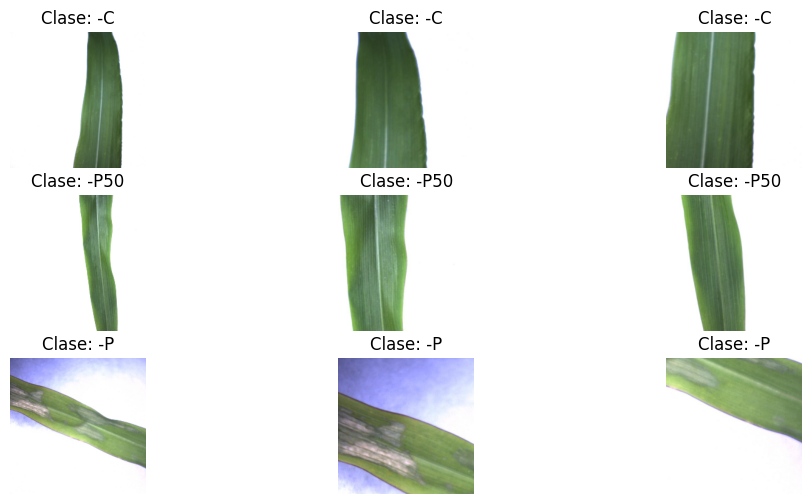

In [4]:
# Sección 4. Visualización ejemplo de imágenes por clase
# ------------------------------------------
# 4. Visualización ejemplo de imágenes por clase
# ------------------------------------------
# Justificación:
# Visualizar imágenes permite tener un primer contacto con los datos y verificar que la carga es correcta.

def mostrar_imagenes_ejemplo(imagenes, etiquetas, clases, num_por_clase=3):
    plt.figure(figsize=(12, 6))
    clases_inv = {v: k for k, v in clases.items()}
    
    mostradas = {k: 0 for k in clases_inv.keys()}
    total_mostradas = 0
    
    for i, (img, etiq) in enumerate(zip(imagenes, etiquetas)):
        if mostradas[etiq] < num_por_clase:
            plt.subplot(len(clases), num_por_clase, total_mostradas + 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f"Clase: {clases_inv[etiq]}")
            plt.axis('off')
            mostradas[etiq] += 1
            total_mostradas += 1
            if total_mostradas >= num_por_clase * len(clases):
                break
    plt.show()

mostrar_imagenes_ejemplo(imagenes, etiquetas, clases)

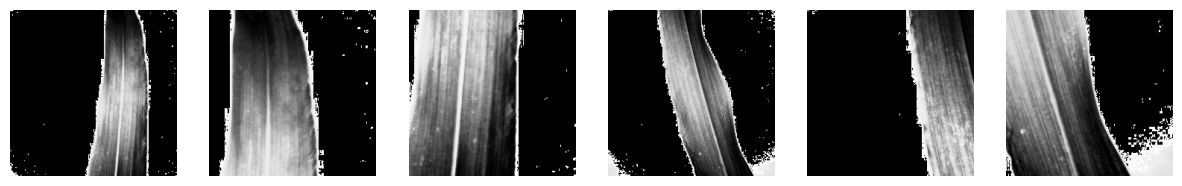

In [5]:
# Sección 5. Preprocesamiento: Escala de grises, ecualización y segmentación para eliminar fondo blanco
# ------------------------------------------
# 5. Preprocesamiento: Escala de grises, ecualización y segmentación para eliminar fondo blanco
# ------------------------------------------
# Justificación:
# Convertimos a gris para usar HOG que trabaja mejor con imágenes en escala de grises.
# Aplicamos ecualización para mejorar contraste y compensar variaciones de iluminación.
# Usamos segmentación simple para eliminar el fondo blanco que podría interferir con el cálculo de gradientes.

def preprocesar_imagen(imagen):
    # Convertir a escala de grises
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    
    # Ecualizar histograma para mejorar contraste
    ecualizada = cv2.equalizeHist(gris)
    
    # Segmentación simple: se crea máscara para eliminar fondo blanco (pixel muy claro)
    _, mascara = cv2.threshold(ecualizada, 250, 255, cv2.THRESH_BINARY_INV)
    
    # Aplicar máscara para conservar solo hoja
    segmentada = cv2.bitwise_and(ecualizada, ecualizada, mask=mascara)
    
    return segmentada

# Probar preprocesamiento con algunas imágenes
imagenes_preprocesadas = [preprocesar_imagen(img) for img in imagenes]

# Visualizamos las primeras imágenes preprocesadas
def mostrar_imagenes_gris(imagenes_pre, num=6):
    plt.figure(figsize=(15, 6))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.imshow(imagenes_pre[i], cmap='gray')
        plt.axis('off')
    plt.show()

mostrar_imagenes_gris(imagenes_preprocesadas)

In [6]:
# Sección 6. Extracción de características HOG
# ------------------------------------------
# 6. Extracción de características HOG
# ------------------------------------------
# Justificación:
# HOG es un descriptor robusto que captura información de gradientes y bordes,
# ideal para diferenciar texturas y formas como las que presentan las hojas con distintas deficiencias.

def extraer_hog(imagen):
    caracteristicas, _ = hog(imagen,
                             orientations=9,
                             pixels_per_cell=(16, 16),
                             cells_per_block=(2, 2),
                             block_norm='L2-Hys',
                             visualize=True)
    return caracteristicas

# Extraer características para todas las imágenes preprocesadas
X = np.array([extraer_hog(img) for img in imagenes_preprocesadas])
y = np.array(etiquetas)

print(f"Dimensiones matriz características X: {X.shape}")

Dimensiones matriz características X: (2776, 6084)


In [7]:
# Sección 7. Implementación de Árbol de Decisión con Validación Cruzada Estratificada
# ------------------------------------------
# 7. Implementación de Árbol de Decisión con Validación Cruzada Estratificada
# ------------------------------------------
# Justificación:
# Usamos validación cruzada para evaluar la capacidad de generalización del modelo sin usar un set fijo de prueba,
# garantizando que cada parte del dataset se use para entrenamiento y evaluación.
# La estratificación mantiene la proporción de clases en cada fold.

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
f1s = []
precisiones = []
recalls = []
matrices_confusion = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    modelo = DecisionTreeClassifier(random_state=42)
    modelo.fit(X_train, y_train)
    
    y_pred = modelo.predict(X_test)
    
    accuracies.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred, average='weighted'))
    precisiones.append(precision_score(y_test, y_pred, average='weighted'))
    recalls.append(recall_score(y_test, y_pred, average='weighted'))
    matrices_confusion.append(confusion_matrix(y_test, y_pred))
    
    print(f"Fold {fold} - Accuracy: {accuracies[-1]:.3f}, F1-Score: {f1s[-1]:.3f}")

print("\nResultados promedio en validación cruzada:")
print(f"Accuracy promedio: {np.mean(accuracies):.3f}")
print(f"F1-Score promedio: {np.mean(f1s):.3f}")
print(f"Precisión promedio: {np.mean(precisiones):.3f}")
print(f"Recall promedio: {np.mean(recalls):.3f}")

Fold 1 - Accuracy: 0.561, F1-Score: 0.560
Fold 2 - Accuracy: 0.537, F1-Score: 0.536
Fold 3 - Accuracy: 0.535, F1-Score: 0.534
Fold 4 - Accuracy: 0.508, F1-Score: 0.509
Fold 5 - Accuracy: 0.510, F1-Score: 0.511

Resultados promedio en validación cruzada:
Accuracy promedio: 0.530
F1-Score promedio: 0.530
Precisión promedio: 0.531
Recall promedio: 0.530


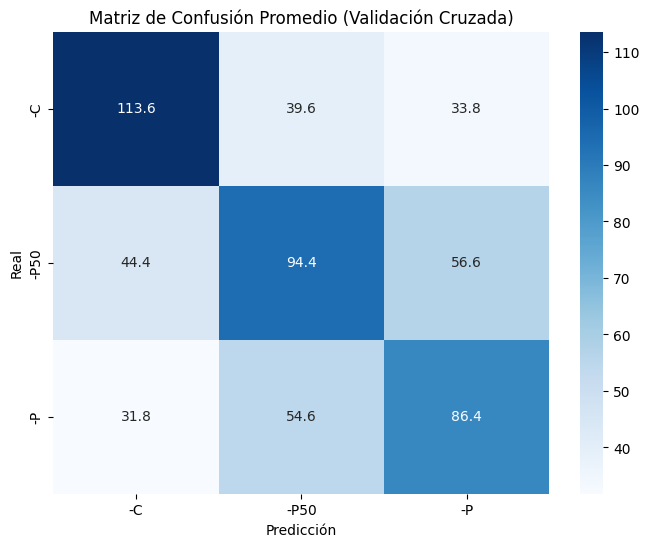

In [8]:
# Sección 8. Visualización de matriz de confusión promedio
# ------------------------------------------
# 8. Visualización de matriz de confusión promedio
# ------------------------------------------
# Justificación:
# La matriz de confusión permite visualizar los aciertos y errores por clase,
# mostrando en detalle dónde el modelo puede estar confundiendo clases.

# Matriz de confusión promedio
cm_promedio = np.mean(matrices_confusion, axis=0)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_promedio, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=clases.keys(), yticklabels=clases.keys())
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Promedio (Validación Cruzada)')
plt.show()

### Interpretación de resultados de la clasificación inicial

En esta sección evaluamos el desempeño del modelo de Árbol de Decisión utilizando características HOG extraídas de las imágenes de hojas de maíz. Observamos las siguientes métricas promedio obtenidas con validación cruzada estratificada:

- **Exactitud (Accuracy)**: indica la proporción de predicciones correctas sobre el total. - **F1-Score**: promedio armónico de precisión y recall, útil para clases desbalanceadas.

Los valores reportados son relativamente bajos, lo que sugiere que el modelo actual no captura completamente la variabilidad de las deficiencias de fósforo en las hojas. Esto motiva la segunda parte del notebook, donde ajustamos parámetros y exploramos modelos alternativos para mejorar estas métricas.


# Mejoramiento de métricas

In [9]:
# Sección 1. Ajuste de parámetros HOG y canales de color
# ------------------------------------------
# 1. Ajuste de parámetros HOG y canales de color
# ------------------------------------------

from skimage.feature import hog
import cv2
import numpy as np
from joblib import Parallel, delayed

In [10]:
# Sección 1. Ajuste de parámetros HOG y paralelización
# ------------------------------------------
# 1. Ajuste de parámetros HOG y paralelización
# ------------------------------------------

def extraer_hog_con_ajustes(imagen, orientaciones=6, pixels_por_celda=(4, 4), celdas_por_bloque=(2, 2)):
    # Extraemos características HOG directamente de la imagen en escala de grises
    caracteristicas = hog(imagen, orientations=orientaciones, pixels_per_cell=pixels_por_celda,
                          cells_per_block=celdas_por_bloque, block_norm='L2-Hys', visualize=False)  # Cambiado visualize a False
    return caracteristicas

def extraer_hog_por_canales(imagen, orientaciones=6, pixels_por_celda=(4, 4), celdas_por_bloque=(2, 2)):
    # Convertimos la imagen a sus canales RGB
    canales = cv2.split(imagen)
    
    # Extraemos HOG para cada canal (Rojo, Verde, Azul)
    hog_canales = []
    for canal in canales:
        # No convertimos a escala de grises, ya que cada canal es 2D
        caracteristicas = extraer_hog_con_ajustes(canal, orientaciones, pixels_por_celda, celdas_por_bloque)
        hog_canales.append(caracteristicas)
    
    # Concatenamos las características de los 3 canales
    return np.concatenate(hog_canales)

# Paralelización de la extracción de HOG para todas las imágenes
imagenes_hog = Parallel(n_jobs=4)(delayed(extraer_hog_por_canales)(img, orientaciones=6, pixels_por_celda=(4, 4), celdas_por_bloque=(2, 2)) for img in imagenes)

# Mostrar las dimensiones de las características extraídas
print(f"Características HOG extraídas, dimensiones: {np.array(imagenes_hog).shape}")

Características HOG extraídas, dimensiones: (2776, 217800)


In [12]:
from joblib import Parallel, delayed
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes_hog, etiquetas, test_size=0.3, random_state=42)

# Definir las funciones para entrenar los modelos y obtener resultados
def entrenar_random_forest(X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier(class_weight='balanced', random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    return ("Random Forest", accuracy_score(y_test, y_pred_rf), classification_report(y_test, y_pred_rf))

def entrenar_svm(X_train, y_train, X_test, y_test):
    svm = SVC(class_weight='balanced', random_state=42)
    svm.fit(X_train, y_train)
    y_pred_svm = svm.predict(X_test)
    return ("SVM", accuracy_score(y_test, y_pred_svm), classification_report(y_test, y_pred_svm))

def entrenar_mlp(X_train, y_train, X_test, y_test):
    mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
    mlp.fit(X_train, y_train)
    y_pred_mlp = mlp.predict(X_test)
    return ("MLP", accuracy_score(y_test, y_pred_mlp), classification_report(y_test, y_pred_mlp))

# Crear la lista de tareas a paralelizar
modelos = [
    delayed(entrenar_random_forest)(X_train, y_train, X_test, y_test),
    delayed(entrenar_svm)(X_train, y_train, X_test, y_test),
    delayed(entrenar_mlp)(X_train, y_train, X_test, y_test)
]

# Paralelización de los modelos
resultados = Parallel(n_jobs=4)(modelos)

# Imprimir los resultados de cada modelo
for modelo, accuracy, report in resultados:
    print(f"Resultados para el modelo {modelo}:")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(report)
    print("-" * 80)


d:\MAESTRIA_CIENCIAS_DE_LOS_DATOS\SEMESTRE 2025-I\VISION\Taller_1\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Resultados para el modelo Random Forest:
Accuracy: 0.6554621848739496
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.84      0.73       274
           1       0.65      0.63      0.64       293
           2       0.70      0.49      0.58       266

    accuracy                           0.66       833
   macro avg       0.66      0.65      0.65       833
weighted avg       0.66      0.66      0.65       833

--------------------------------------------------------------------------------
Resultados para el modelo SVM:
Accuracy: 0.6890756302521008
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.86      0.77       274
           1       0.68      0.55      0.61       293
           2       0.69      0.66      0.67       266

    accuracy                           0.69       833
   macro avg       0.69      0.69      0.68       833
weighted avg       0.69      0.69   

### Interpretación de resultados de los modelos ajustados

En esta sección analizamos el desempeño de tres modelos ajustados (Random Forest, SVM y MLP) tras aplicar paralelización y ajuste de hiperparámetros: Clase 0:Hojas sin deficiencia.Clase 1:Hojas con deficiencia del 50% de fósforo. Clase 2:Hojas con deficiencia del 100% de fósforo.

- **Random Forest**  
  - **Accuracy**: 0.655  
  - **F1-Score macro promedio**: 0.65  
  - Observamos un buen desempeño en la clase 0 (F1=0.73) pero menor sensibilidad en la clase 2 (F1=0.58), lo que indica que el bosque aleatorio tiene dificultades para identificar correctamente la deficiencia en la clase 2.

- **SVM**  
  - **Accuracy**: 0.689  
  - **F1-Score macro promedio**: 0.68  
  - El SVM mejora la precisión global, destacando en la detección de la clase 0 (F1=0.77) y mostrando un balance más uniforme entre clases, aunque la clase 1 tiene un recall menor (0.55).

- **MLP (Perceptrón Multicapa)**  
  - **Accuracy**: 0.627  
  - **F1-Score macro promedio**: 0.62  
  - El MLP presenta un rendimiento inferior al SVM y Random Forest, especialmente en la clase 2 (F1=0.57), lo que sugiere que la red neuronal no generaliza tan bien con los parámetros actuales.
